In [1]:
import sys
import torch

sys.path.insert(0, "..")
basedir = "../.."

from common.config import create_object, load_config

%matplotlib widget

torch._dynamo.config.suppress_errors = True
torch._dynamo.disable()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# dconfig = load_config("../autoencoder/configs/data/burgersshift.yaml")
# dconfig.datasize.spacedim = 1
# dset = create_object(dconfig)

Average Relative L2 Error over all times: 0.0372


C:\Users\Admin\AppData\Local\Temp\ipykernel_19044\2198616143.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(9, 3))


interactive(children=(IntSlider(value=0, description='i', max=249), Output()), _dom_classes=('widget-interact'…

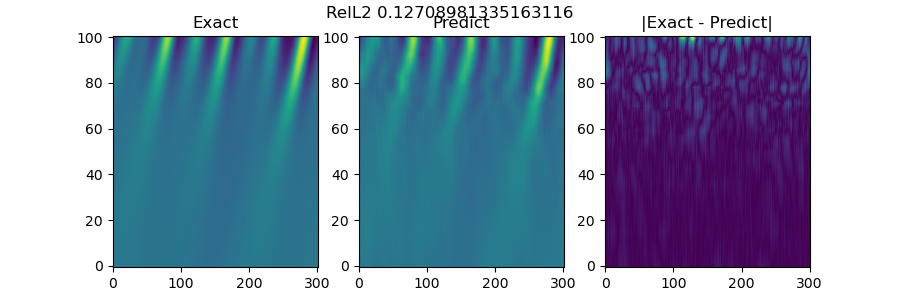

In [53]:
LTINetHelper.plot_op_predicts(test, topdown=True)

In [52]:
import time
import glob
import datetime
import copy
import os
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import matplotlib.cm as cm

import itertools

from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from copy import deepcopy

import utils

class LTINetHelper():
  def __init__(self, config):
    self.update_config(config)

  def update_config(self, config):
    self.config = deepcopy(config)

  def create_ltinet(self, dataset, config=None, **args):
    if config is None:
      config = self.config

    assert(len(dataset.data.shape) < 4)
    if len(dataset.data.shape) == 3:
      din = dataset.params.shape[-1]
      dout = dataset.data.shape[-1]

    td = args.get("td", None)
    seed = args.get("seed", 0)
    device = args.get("device", 0)

    recclass = globals()[args.get("recclass", config.recclass)]
    recparams = copy.deepcopy(dict(args.get("recparams", config.recparams)))

    recparams["seq"][0] = din + 1
    recparams["seq"][-1] = dout

    return LTINet(dataset, recclass, recparams, td=td, seed=seed, device=device)

  @staticmethod
  def get_operrs(ltinet, times=None, testonly=False):
    if testonly:
      data = ltinet.dataset.data[ltinet.numtrain:, 1:]
      params = ltinet.dataset.params[ltinet.numtrain:,]
    else:
      data = ltinet.dataset.data[:, 1:]
      params = ltinet.dataset.params

    errors = ltinet.get_errors(data, params, times=times, aggregate=False)

    return errors
  
  @staticmethod
  def plot_op_predicts(ltinet, testonly=False, xs=None, cmap="viridis", topdown=True):
    if testonly:
      data = ltinet.dataset.data[ltinet.numtrain:,]
      params = ltinet.dataset.params[ltinet.numtrain:,]
    else:
      data = ltinet.dataset.data
      params = ltinet.dataset.params

    if xs == None:
      xs = np.linspace(0, 1, len(data[0, 0]))

    params = torch.tensor(np.float32(params)).to(ltinet.device)

    predicts = ltinet.propagate(params).cpu().detach().numpy()

    errors = []
    n = predicts.shape[0]
    for s in range(data.shape[1]):
      currpredict = predicts[:, s].reshape((n, -1))
      currreference = data[:, s].reshape((n, -1))
      errors.append(np.mean(np.linalg.norm(currpredict - currreference, axis=1) / np.linalg.norm(currreference, axis=1)))
        
    print(f"Average Relative L2 Error over all times: {np.mean(errors):.4f}")

    if len(data.shape) == 3:
      if topdown:
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
         
      else:
        fig, ax = plt.subplots(figsize=(4, 3))

    if topdown:
      @widgets.interact(i=(0, n-1))
      def plot_interact(i=0):
        if len(data.shape) == 3:
          axes[0].clear()
          axes[1].clear()
          axes[2].clear()

          fig.suptitle(f"RelL2 {np.linalg.norm(predicts[i, s-1] - data[i, s]) / np.linalg.norm(data[i, s])}")

          axes[0].set_title("Exact")
          axes[0].imshow(data[i], cmap=cmap, origin="lower", aspect='auto')

          axes[1].set_title("Predict")
          axes[1].imshow(predicts[i], cmap=cmap, origin="lower", aspect='auto')

          axes[2].set_title("|Exact - Predict|")
          axes[2].imshow(np.abs(data[i] - predicts[i]), cmap=cmap, origin="lower", aspect='auto')
       
    else:
      @widgets.interact(i=(0, n-1), s=(1, ltinet.T-1))
      def plot_interact(i=0, s=1):
        print(f"Avg Relative L2 Error for t0 to t{s}: {errors[s-1]:.4f}")

        if len(data.shape) == 3:
          ax.clear()
          ax.set_title(f"RelL2 {np.linalg.norm(predicts[i, s-1] - data[i, s]) / np.linalg.norm(data[i, s])}")
          ax.plot(xs, data[i, 0], label="Input", linewidth=1)
          ax.plot(xs, predicts[i, s-1], label="Predicted", linewidth=1)
          ax.plot(xs, data[i, s], label="Exact", linewidth=1)
          ax.legend()

  @staticmethod
  def plot_errorparams(ltinet, param=-1):
    if param == -1:
        # Auto-detect one varying parameter
        param = 0
        P = ltinet.dataset.params.shape[1]
        for p in range(P):
            if np.abs(ltinet.dataset.params[0, p] - ltinet.dataset.params[1, p]) > 0:
                param = p
                break

    l2error = np.asarray(LTINetHelper.get_operrs(ltinet, times=[ltinet.T - 1]))
    params = ltinet.dataset.params

    print(params.shape, l2error.shape)

    if isinstance(param, (list, tuple, np.ndarray)) and len(param) == 2:
        # 3D scatter plot for 2 varying parameters
        x = params[:, param[0]]
        y = params[:, param[1]]
        z = l2error

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=10)

        ax.set_xlabel(f"Param {param[0]}")
        ax.set_ylabel(f"Param {param[1]}")
        ax.set_zlabel("Operator Error")
        fig.colorbar(sc, ax=ax, label="Operator Error")

    else:
        # Fallback to 2D scatter if param is 1D
        fig, ax = plt.subplots()
        ax.scatter(params[:, param], l2error, s=2)
        ax.set_xlabel(f"Parameter {param}")
        ax.set_ylabel("Operator Error")

    fig.tight_layout()

class LTINet():
  def __init__(self, dataset, recclass, recparams, td, seed, device):
    self.dataset = dataset
    self.device = device
    self.td = td
    self.f = self.dataset.params.shape[1]
  
    if self.td is None:
      self.prefix = f"{self.dataset.name}{str(recclass.__name__)}LTINet"
    else:
      self.prefix = self.td

    torch.manual_seed(seed)
    np.random.seed(seed)
    self.seed = seed

    datacopy = self.dataset.data.copy()
    self.numtrain = int(datacopy.shape[0] * 0.8)
    
    self.T = self.dataset.data.shape[1]
    self.trainarr = datacopy[:self.numtrain]
    self.testarr = datacopy[self.numtrain:]
    self.trainparams = self.dataset.params[:self.numtrain]
    self.testparams = self.dataset.params[self.numtrain:]
    self.optparams = None

    self.datadim = len(self.dataset.data.shape) - 2

    self.recclass = recclass
    self.recparams = copy.deepcopy(recparams)

    recparams["seq"][0] = self.f + 1
    recparams["seq"][-1] = self.dataset.data.shape[-1]

    self.recnet = recclass(**recparams).float().to(device)

    self.metadata = {
      "recclass": recclass.__name__,
      "recparams": recparams,
      "dataset_name": dataset.name,
      "data_shape": list(dataset.data.shape),
      "data_checksum": float(np.sum(dataset.data)),
      "seed": seed,
      "epochs": []
    }

  def propagate(self, code, start=0, end=-1):
    fullts = torch.linspace(0, 1, self.T).float().to(self.device)
    
    if end > 0:
      ts = fullts[start:end+1]
    else:
      ts = fullts[start:]

    out = self.forward(code, ts)
    return out

  def get_errors(self, testarr, testparams, ords=(2,), times=None, aggregate=True):
    assert(aggregate or len(ords) == 1)
    
    if isinstance(testarr, np.ndarray):
      testarr = torch.tensor(testarr, dtype=torch.float32)

    if isinstance(testparams, np.ndarray):
      testparams = torch.tensor(testparams, dtype=torch.float32)

    if times is None:
      times = range(self.T-1)
  
    out = self.propagate(testparams)

    n = testarr.shape[0]
    orig = testarr.cpu().detach().numpy()
    out = out.cpu().detach().numpy()

    if aggregate:
      orig = orig.reshape([n, -1])
      out = out.reshape([n, -1])
      testerrs = []
      for o in ords:
        testerrs.append(np.mean(np.linalg.norm(orig - out, axis=1, ord=o) / np.linalg.norm(orig, axis=1, ord=o)))

      return tuple(testerrs)
    
    else:
      o = ords[0]
      testerrs = []

      if len(times) == 1:
        t = times[0]
        origslice = orig[:, t].reshape([n, -1])
        outslice = out[:, t].reshape([n, -1])
        return np.linalg.norm(origslice - outslice, axis=1, ord=o) / np.linalg.norm(origslice, axis=1, ord=o)
      else:
        for t in range(orig.shape[1]):
          origslice = orig[:, t].reshape([n, -1])
          outslice = out[:, t].reshape([n, -1])
          testerrs.append(np.mean(np.linalg.norm(origslice - outslice, axis=1, ord=o) / np.linalg.norm(origslice, axis=1, ord=o)))

        return testerrs

  def forward(self, z, ts):
    z_shape = z.shape
    *leading_dims, N = z_shape
    T = ts.shape[0]

    z_expanded = z.unsqueeze(-2).expand(*leading_dims, T, N)

    t_shape = [1] * len(leading_dims) + [T, 1]
    t_expanded = ts.view(*t_shape).expand(*leading_dims, T, 1)

    result = torch.cat([z_expanded, t_expanded], dim=-1)

    decoded = self.recnet(result)
    return decoded

  def load_model(self, filename_prefix, verbose=False, min_epochs=0):
    search_path = f"savedmodels/ltinet/{filename_prefix}*.pickle"
    matching_files = glob.glob(search_path)

    print("Searching for model files matching prefix:", filename_prefix)
    if not hasattr(self, "metadata"):
        raise ValueError("Missing self.metadata. Cannot match models without metadata. Ensure model has been initialized with same config.")

    for addr in matching_files:
      try:
          with open(addr, "rb") as handle:
              dic = pickle.load(handle)
      except Exception as e:
          if verbose:
              print(f"Skipping {addr} due to read error: {e}")
          continue

      meta = dic.get("metadata", {})
      is_match = all(
          meta.get(k) == self.metadata.get(k)
          for k in self.metadata.keys()
      )

      # Check if model meets the minimum epoch requirement
      model_epochs = meta.get("epochs")
      if model_epochs is None:
          if verbose:
              print(f"Skipping {addr} due to missing epoch metadata.")
          continue
      elif isinstance(model_epochs, list):  # handle legacy or list format
          if sum(model_epochs) < min_epochs:
              if verbose:
                  print(f"Skipping {addr} due to insufficient epochs ({sum(model_epochs)} < {min_epochs})")
              continue
      elif model_epochs < min_epochs:
          if verbose:
              print(f"Skipping {addr} due to insufficient epochs ({model_epochs} < {min_epochs})")
          continue

      if is_match:
          print("Model match found. Loading from:", addr)
          self.recnet.load_state_dict(dic["recnet"])
          self.metadata["epochs"] = meta.get("epochs")
          if "opt" in dic:     
            self.optparams = dic["opt"]

          return True
      elif verbose:
          print("Metadata mismatch in file:", addr)
          for k in self.metadata:
              print(f"{k}: saved={meta.get(k)} vs current={self.metadata.get(k)}")

    print("Load failed. No matching models found.")
    print("Searched:", matching_files)
    return False

  def train_model(self, epochs, save=True, optim=torch.optim.AdamW, lr=1e-4, printinterval=10, batch=32, ridge=0, loss=None, best=True, verbose=False):
    def train_epoch(dataloader, writer=None, optimizer=None, scheduler=None, ep=0, printinterval=10, loss=None, testarr=None, testparams=None):
      losses = []
      testerrors1 = []
      testerrors2 = []
      testerrorsinf = []

      def closure(values, params):
        optimizer.zero_grad()

        out = self.propagate(params)
        target = values
        
        res = loss(out, target)
        res.backward()
        
        if writer is not None and self.trainstep % 5 == 0:
          writer.add_scalar("main/loss", res, global_step=self.trainstep)

        return res

      for values, params in dataloader:
        self.trainstep += 1
        error = optimizer.step(lambda: closure(values, params))
        losses.append(float(error.cpu().detach()))

      if scheduler is not None:
        scheduler.step(np.mean(losses))

      # print test
      if printinterval > 0 and (ep % printinterval == 0):
        testerr1, testerr2, testerrinf = self.get_errors(testarr, testparams, ords=(1, 2, np.inf))
        if scheduler is not None:
          print(f"{ep+1}: Train Loss {error:.3e}, LR {scheduler.get_last_lr()[-1]:.3e}, Relative LTINet Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")
        else:
          print(f"{ep+1}: Train Loss {error:.3e}, Relative LTINet Error (1, 2, inf): {testerr1:3f}, {testerr2:3f}, {testerrinf:3f}")

        if writer is not None:
            writer.add_scalar("misc/relativeL1error", testerr1, global_step=ep)
            writer.add_scalar("main/relativeL2error", testerr2, global_step=ep)
            writer.add_scalar("misc/relativeLInferror", testerrinf, global_step=ep)

      return losses, testerrors1, testerrors2, testerrorsinf
  
    loss = nn.MSELoss() if loss is None else loss()

    losses, testerrors1, testerrors2, testerrorsinf = [], [], [], []
    self.trainstep = 0

    train = torch.tensor(self.trainarr, dtype=torch.float32).to(self.device)
    params = torch.tensor(self.trainparams, dtype=torch.float32).to(self.device)
    test = self.testarr

    opt = optim(self.recnet.parameters(), lr=lr, weight_decay=ridge)
    scheduler = lr_scheduler.ReduceLROnPlateau(opt, patience=30)
    dataloader = DataLoader(torch.utils.data.TensorDataset(train, params), shuffle=False, batch_size=batch)

    if self.optparams is not None:
      opt.load_state_dict(self.optparams)

    writer = None
    if self.td is not None:
      name = f"./tensorboard/{datetime.datetime.now().strftime('%d-%B-%Y')}/{self.td}/{datetime.datetime.now().strftime('%H.%M.%S')}/"
      writer = torch.utils.tensorboard.SummaryWriter(name)
      print("Tensorboard writer location is " + name)

    print("Number of NN trainable parameters", utils.num_params(self.recnet))
    print(f"Starting training LTINet model at {time.asctime()}...")
    print("train", train.shape, "test", test.shape)
      
    bestdict = { "loss": float(np.inf), "ep": 0 }
    for ep in range(epochs):
      lossesN, testerrors1N, testerrors2N, testerrorsinfN = train_epoch(dataloader, optimizer=opt, scheduler=scheduler, writer=writer, ep=ep, printinterval=printinterval, loss=loss, testarr=test, testparams=self.testparams)
      losses += lossesN; testerrors1 += testerrors1N; testerrors2 += testerrors2N; testerrorsinf += testerrorsinfN

      if best and ep > epochs // 2:
        avgloss = np.mean(lossesN)
        if avgloss < bestdict["loss"]:
          bestdict["recnet"] = self.recnet.state_dict()
          bestdict["opt"] = opt.state_dict()
          bestdict["loss"] = avgloss
          bestdict["ep"] = ep
        elif verbose:
          print(f"Loss not improved at epoch {ep} (Ratio: {avgloss/bestdict['loss']:.2f}) from {bestdict['ep']} (Loss: {bestdict['loss']:.2e})")
      
    print(f"Finished training LTINet model at {time.asctime()}...")

    if best:
      self.recnet.load_state_dict(bestdict["recnet"])
      opt.load_state_dict(bestdict["opt"])

    self.optparams = opt.state_dict()
    self.metadata["epochs"].append(epochs)

    if save:
      now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

      # Compute total training epochs
      total_epochs = sum(self.metadata["epochs"]) if isinstance(self.metadata["epochs"], list) else self.metadata["epochs"]

      filename = (
          f"{self.dataset.name}_"
          f"{self.recclass.__name__}_"
          f"{self.recparams['seq']}_"
          f"{self.seed}_"
          f"{total_epochs}ep_"
          f"{now}.pickle"
      )

      dire = "savedmodels/ltinet"
      addr = os.path.join(dire, filename)

      if not os.path.exists(dire):
          os.makedirs(dire)

      with open(addr, "wb") as handle:
          pickle.dump({
              "recnet": self.recnet.state_dict(),
              "metadata": self.metadata,
              "opt": self.optparams
          }, handle, protocol=pickle.HIGHEST_PROTOCOL)

      print("Model saved at", addr)

    return { "losses": losses, "testerrors1": testerrors1, "testerrors2": testerrors2, "testerrorsinf": testerrorsinf }



In [9]:
dconfig = load_config("../autoencoder/configs/data/droplettrigpoly1.yaml")
dconfig.datasize.spacedim = 1
dset = create_object(dconfig)

#dset.downsample_time(10)

In [10]:
import models
lconfig = load_config("../autoencoder/configs/experiments/ltinet.yaml")
experiment = LTINetHelper(lconfig)

FFNet = models.FFNet
FFAutoencoder = models.FFAutoencoder
test = experiment.create_ltinet(dset)

test.train_model(500, lr=1e-3)

Number of NN trainable parameters 1525901
Starting training LTINet model at Mon Jul 21 09:42:12 2025...
train torch.Size([200, 101, 301]) test (50, 101, 301)
1: Train Loss 1.995e-02, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.365378, 0.430413, 0.751310
11: Train Loss 8.646e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.179339, 0.264450, 0.559458
21: Train Loss 6.885e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.156371, 0.230028, 0.517425
31: Train Loss 5.211e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.137623, 0.199060, 0.501004
41: Train Loss 3.639e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.113556, 0.162682, 0.453220
51: Train Loss 2.625e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.099144, 0.141491, 0.410300
61: Train Loss 2.077e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.086555, 0.126055, 0.389188
71: Train Loss 1.738e-03, LR 1.000e-03, Relative LTINet Error (1, 2, inf): 0.083839, 0.118837, 0.366811
81: Train L

{'losses': [0.10575181990861893,
  0.060946255922317505,
  0.02591438964009285,
  0.029793385416269302,
  0.013238917104899883,
  0.018211480230093002,
  0.019947534427046776,
  0.01839321106672287,
  0.017005205154418945,
  0.016303811222314835,
  0.014401833526790142,
  0.014234011061489582,
  0.011045269668102264,
  0.01178213395178318,
  0.012474519200623035,
  0.012867014855146408,
  0.012092351913452148,
  0.011334238573908806,
  0.013332993723452091,
  0.010723503306508064,
  0.010107286274433136,
  0.01032005064189434,
  0.010999346151947975,
  0.011081124655902386,
  0.00994745921343565,
  0.011009053327143192,
  0.009750143624842167,
  0.009785236790776253,
  0.009606479667127132,
  0.010385552421212196,
  0.010859238915145397,
  0.009671167470514774,
  0.010557661764323711,
  0.009399757720530033,
  0.00956411100924015,
  0.009312656708061695,
  0.010088383220136166,
  0.010464848019182682,
  0.009436224587261677,
  0.010339166037738323,
  0.009159102104604244,
  0.009381750